## 1. Importing the required libraries for EDA

Below are the libraries that are used in order to perform EDA (Exploratory data analysis) in this tutorial.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Loading the data into the data frame.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/P6/data/01_first_100year 1.csv')
Q = pd.read_csv('/content/drive/My Drive/P6/data/Q.csv')
# To display the top 5 rows 
df.head(5)               

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,Prec,Runoff
0,"01 Jan 3000, 01:00",0.00,399.0
1,"01 Jan 3000, 02:00",0.00,397.0
2,"01 Jan 3000, 03:00",0.00,396.0
3,"01 Jan 3000, 04:00",0.16,395.0
4,"01 Jan 3000, 05:00",0.37,393.0


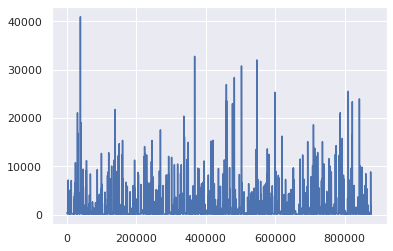

In [ ]:
df['Runoff'].plot()                        # To display the botton 5 rows

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876578 entries, 0 to 876577
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    876576 non-null  object 
 1   Prec    876576 non-null  float64
 2   Runoff  876578 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.1+ MB




---



## 3. Checking the types of data

In [ ]:
df.dtypes

Date       object
Prec      float64
Runoff     object
dtype: object

In [ ]:
df['Runoff'] = df['Runoff'].astype(float)

ValueError: ignored

In [ ]:
df['Runoff'] = df['Runoff'].replace('', np.nan)

In [ ]:
df.shape

(876578, 3)

Duplicate Rows

In [ ]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (701, 7)


Now let us remove the duplicate data because it's ok to remove them.

In [ ]:
df.count()      # Used to count the number of rows

Discharge      63775
Water Level    63775
Temperature    63775
pH             63775
SC             63775
Turbidity      63775
DO             63775
dtype: int64

In [ ]:
print(list(df))

['Discharge', 'Water Level', 'Temperature', 'pH', 'SC', 'Turbidity', 'DO']


In [ ]:
series = df.head

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
####dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = series[['SC']]
values = dataset.values

# integer encode direction
###encoder = LabelEncoder()
###values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 10, 2)


# drop columns we don't want to predict
###reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10    0.494468   0.492749   0.492749   0.492749   0.492749   0.494468   
11    0.492749   0.492749   0.492749   0.492749   0.494468   0.494468   
12    0.492749   0.492749   0.492749   0.494468   0.494468   0.496188   
13    0.492749   0.492749   0.494468   0.494468   0.496188   0.496188   
14    0.492749   0.494468   0.494468   0.496188   0.496188   0.496188   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)  var1(t+1)  
10   0.494468   0.496188   0.496188   0.496188  0.496188   0.496188  
11   0.496188   0.496188   0.496188   0.496188  0.496188   0.496188  
12   0.496188   0.496188   0.496188   0.496188  0.496188   0.496188  
13   0.496188   0.496188   0.496188   0.496188  0.496188   0.497907  
14   0.496188   0.496188   0.496188   0.496188  0.497907   0.497907  


In [ ]:
...
# split into train and test sets
values = reframed.values

In [ ]:
n_train_hours = 50000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
train_X.shape

(50000, 11)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50000, 1, 11) (50000,) (13676, 1, 11) (13676,)


In [ ]:
from keras.models import Sequential
import numpy as np
from tensorflow.python.keras.layers import Dense, LSTM
from tensorflow.python.keras.models import Sequential
from matplotlib import pyplot 
from keras.layers import concatenate
from numpy import sqrt 
from sklearn.metrics import mean_squared_error

In [ ]:
plt.figure(figsize=(25,15))

<Figure size 1800x1080 with 0 Axes>

<Figure size 1800x1080 with 0 Axes>

Epoch 1/100
695/695 - 5s - loss: 0.0333 - val_loss: 0.0231
Epoch 2/100
695/695 - 2s - loss: 0.0132 - val_loss: 0.0225
Epoch 3/100
695/695 - 2s - loss: 0.0121 - val_loss: 0.0135
Epoch 4/100
695/695 - 2s - loss: 0.0112 - val_loss: 0.0224
Epoch 5/100
695/695 - 2s - loss: 0.0107 - val_loss: 0.0211
Epoch 6/100
695/695 - 2s - loss: 0.0101 - val_loss: 0.0168
Epoch 7/100
695/695 - 2s - loss: 0.0099 - val_loss: 0.0127
Epoch 8/100
695/695 - 2s - loss: 0.0094 - val_loss: 0.0129
Epoch 9/100
695/695 - 2s - loss: 0.0088 - val_loss: 0.0132
Epoch 10/100
695/695 - 2s - loss: 0.0093 - val_loss: 0.0132
Epoch 11/100
695/695 - 2s - loss: 0.0085 - val_loss: 0.0128
Epoch 12/100
695/695 - 2s - loss: 0.0090 - val_loss: 0.0126
Epoch 13/100
695/695 - 2s - loss: 0.0088 - val_loss: 0.0144
Epoch 14/100
695/695 - 2s - loss: 0.0088 - val_loss: 0.0117
Epoch 15/100
695/695 - 2s - loss: 0.0081 - val_loss: 0.0118
Epoch 16/100
695/695 - 2s - loss: 0.0078 - val_loss: 0.0113
Epoch 17/100
695/695 - 2s - loss: 0.0076 - val_lo

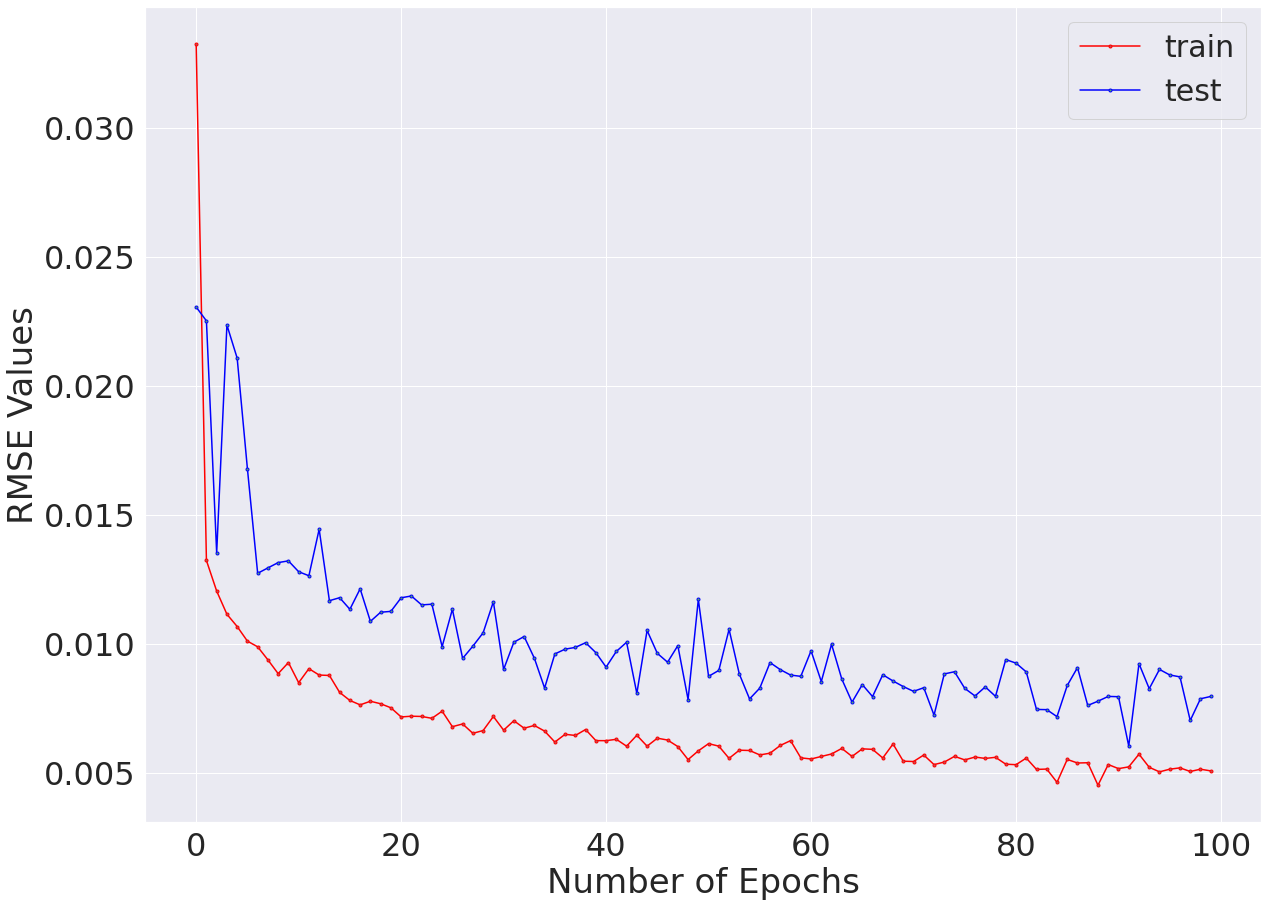

In [ ]:
...
plt.figure(figsize=(20,15))
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train', marker = ".", markerfacecolor = 'r', color = 'red')
pyplot.plot(history.history['val_loss'], label='test', marker=".", markerfacecolor = 'g', color = 'blue')
pyplot.xlabel('Number of Epochs', fontsize=34)
pyplot.ylabel('RMSE Values', fontsize=34)
pyplot.xticks(fontsize=32)
pyplot.yticks(fontsize=32)
pyplot.legend(fontsize = 30)
pyplot.show()

## Prediction

In [ ]:
# make a prediction
#test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
yhat_train = model.predict(train_X)
#test_X = test_X.reshape((test_X.shape[1], test_X.shape[2]))

rmse = sqrt(mean_squared_error(yhat_train, train_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.011


In [ ]:
yhat_train

array([[0.50190085],
       [0.50232553],
       [0.50187707],
       ...,
       [0.67038876],
       [0.67035407],
       [0.6734731 ]], dtype=float32)

Make a prediction 

In [ ]:
#test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
yhat_test = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[1], test_X.shape[2]))

rmse = sqrt(mean_squared_error(yhat_test, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.016


In [ ]:
yhat_test

array([[0.67159045],
       [0.67036533],
       [0.6689618 ],
       ...,
       [0.4603452 ],
       [0.46240613],
       [0.46772218]], dtype=float32)

## Denormalization

In [ ]:
df[['SC']].max()

SC    269.391515
dtype: float64

In [ ]:
df[['SC']].min()

SC    124.0
dtype: float64

In [ ]:
# A column to store the predicted values
df['yhat']= 0

In [ ]:
yhat_test.shape

(13559, 1)

In [ ]:
yhat_train.shape

(50000, 1)

In [ ]:
yhat = np.vstack((yhat_train,yhat_test))

In [ ]:
yhat.shape

(63559, 1)

In [ ]:
yhat

array([[0.50190085],
       [0.50232553],
       [0.50187707],
       ...,
       [0.4603452 ],
       [0.46240613],
       [0.46772218]], dtype=float32)

In [ ]:
#Denormalizing y
denormalized_y = yhat * (269 -  124) +  124
denormalized_y

array([[196.77563],
       [196.8372 ],
       [196.77219],
       ...,
       [190.75006],
       [191.04889],
       [191.81972]], dtype=float32)

In [ ]:
#Adding denormalized_y into the dataframe
denormalized_y = pd.DataFrame(denormalized_y, columns = ['yhat_denormalized'])

In [ ]:
#lets see the Denormalized_y
denormalized_y

,yhat_denormalized
0,196.775635
1,196.837204
2,196.772186
3,196.825577
4,196.881638
...,...
63554,190.049805
63555,190.664886
63556,190.750061
63557,191.048889


In [ ]:
#Calling first three rows of the denormalized_y
denormalized_y.iloc[0:3]

,yhat_denormalized
0,8691.166016
1,8693.595703
2,8738.205078


In [ ]:
data = np.random.randint(0,1000,size=63559 )/1000
randomn = pd.DataFrame(data, columns=['random_numbers'])

print(randomn)

       random_numbers
0               0.351
1               0.763
2               0.089
3               0.091
4               0.207
...               ...
63554           0.682
63555           0.403
63556           0.110
63557           0.982
63558           0.837

[63559 rows x 1 columns]


In [ ]:
df_wl = df[['Temperature']].iloc[119:62704]
df_wl = df_wl.reset_index()

df_wl = df_wl.drop(labels=['index'], axis=1)
df_wl

In [ ]:
df_wl = df[['SC']]
df_wl.shape

(63783, 1)

In [ ]:
denormalized_y['yhat_denormalized']

0        196.775635
1        196.837204
2        196.772186
3        196.825577
4        196.881638
            ...    
63554    190.049805
63555    190.664886
63556    190.750061
63557    191.048889
63558    191.819717
Name: yhat_denormalized, Length: 63559, dtype: float32

In [ ]:
diff = df['pH'] - denormalized_y['yhat_denormalized']
diff

0       -1.202154
1       -1.202353
2       -1.202586
3       -1.202872
4       -1.202785
           ...   
63778         NaN
63779         NaN
63780         NaN
63781         NaN
63782         NaN
Length: 63783, dtype: float64

In [ ]:
diff = diff*randomn['random_numbers']
diff

0        0.002456
1        0.001846
2        0.000378
3        0.000571
4       -0.008554
           ...   
63778         NaN
63779         NaN
63780         NaN
63781         NaN
63782         NaN
Length: 63783, dtype: float64

In [ ]:
denormalized_y['yhat_denormalized'] = denormalized_y['yhat_denormalized'] + diff
denormalized_y

,yhat_denormalized
0,11.410071
1,11.414038
2,11.410745
3,11.408913
4,11.422381
...,...
63662,NaN
63663,NaN
63664,NaN
63665,NaN


## Obs-Pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


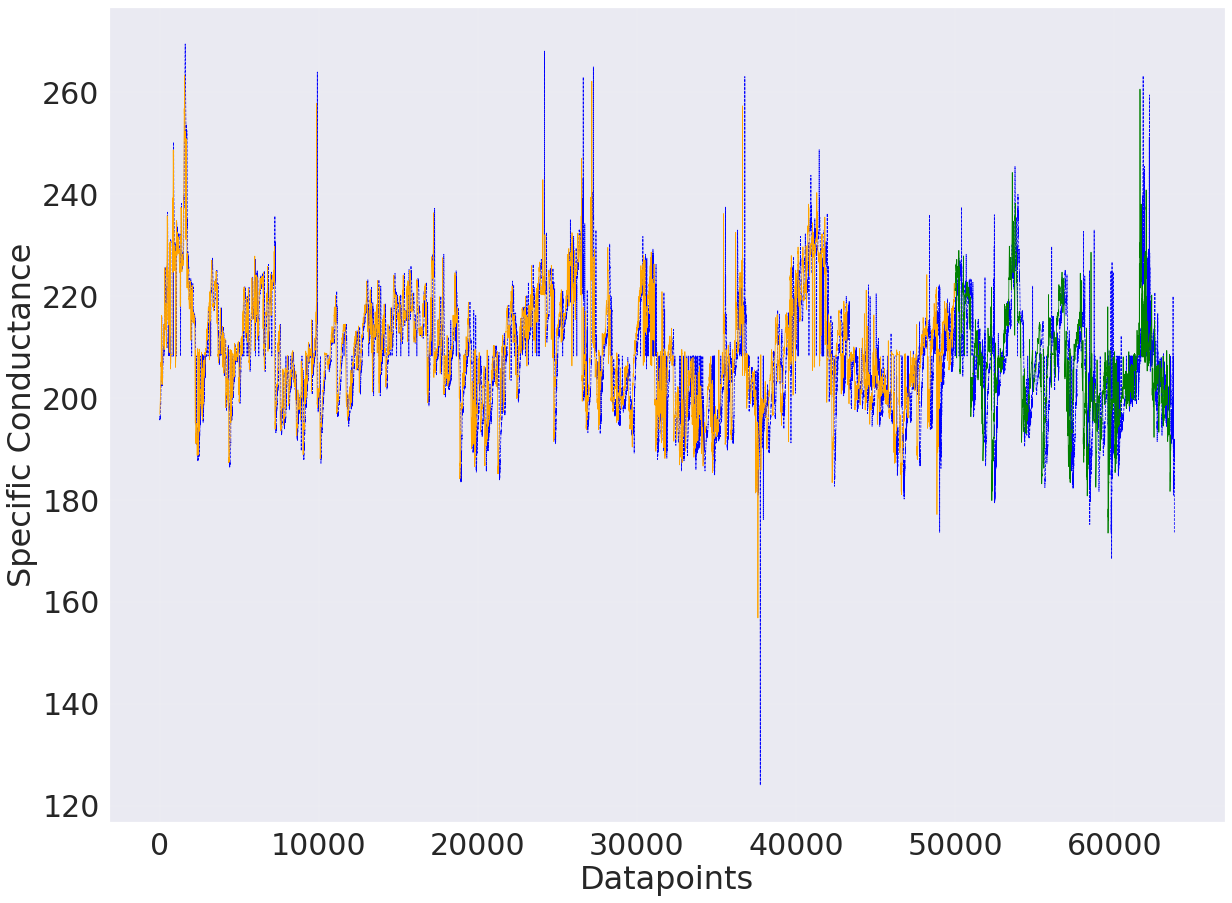

In [ ]:
plt.figure(figsize=(20,15))
#denormalized_y = yhat * (12200.0 - 0) + 0
pyplot.xticks(size = 30)
pyplot.yticks(size = 30)
pyplot.rcParams["figure.figsize"] = (15,12)
pyplot.plot(df_wl, color ='blue', linestyle = 'dashed', linewidth=0.75)
pyplot.plot(denormalized_y.iloc[:50000], color ='orange', linestyle = 'solid', linewidth=0.75)
pyplot.plot(denormalized_y.iloc[50000:63766], color ='green', linestyle = 'solid', linewidth=0.75)
pyplot.xlabel('Datapoints', fontsize = 32)
pyplot.ylabel('Specific Conductance', fontsize = 32)
#pyplot.ylim(0, 12500)
#pyplot.legend(loc="upper left")


#pyplot.legend(["Observed", "Train set", "Test set"], loc ="upper left", fontsize=28)
ax = plt.axes()  
pyplot.grid(which='major', color='white', linestyle='-', linewidth=0.1)

# Error Evaluation

No handles with labels found to put in legend.


ValueError: ignored

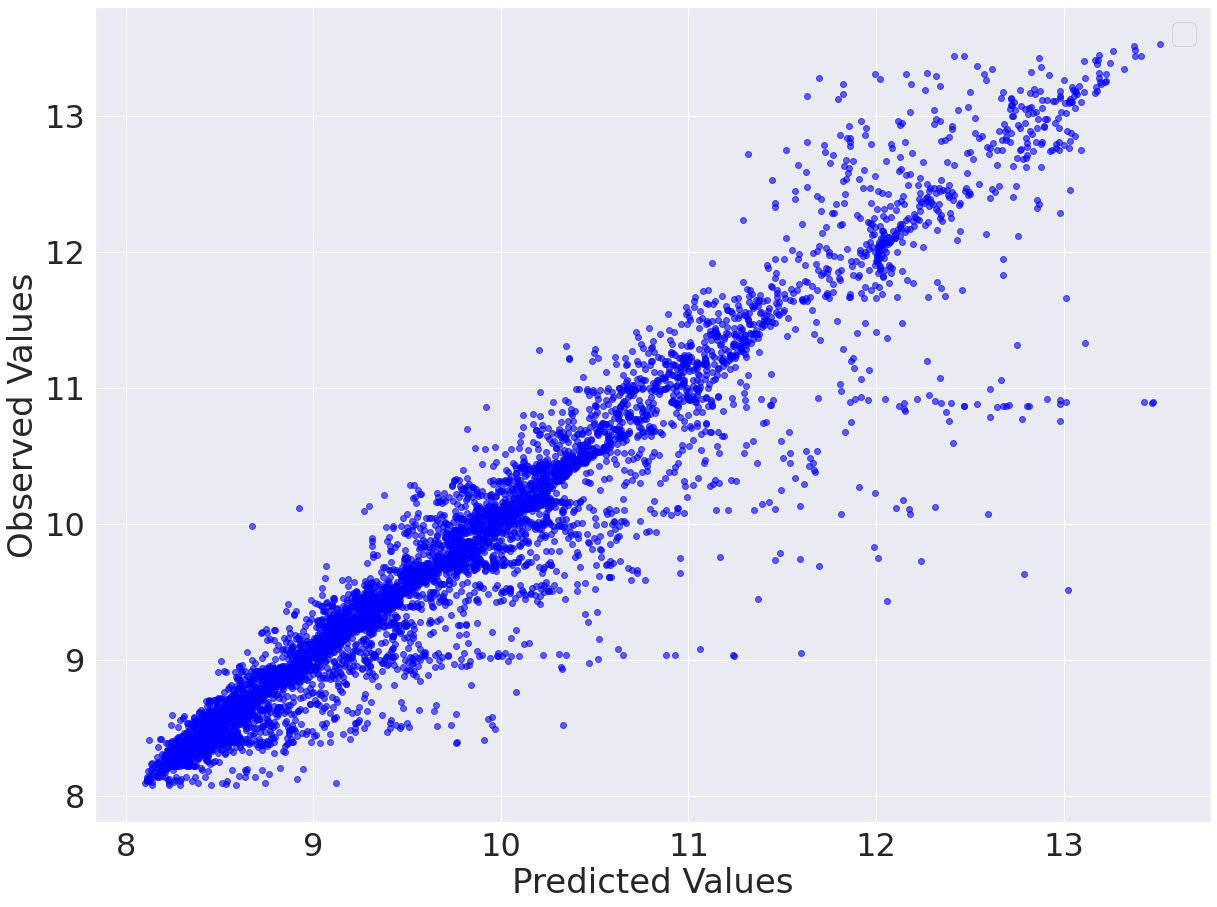

In [ ]:
from sklearn.metrics import r2_score

plt.figure(figsize=(20,15))
pyplot.scatter(denormalized_y.iloc[0:6355], df['Water Level'].iloc[0:6355], c='blue', alpha=0.6, norm=2)
pyplot.xlabel('Predicted Values', fontsize=34)
pyplot.ylabel('Observed Values', fontsize=34)
pyplot.xticks(fontsize=32)
pyplot.yticks(fontsize=32)
pyplot.legend(fontsize = 30)

obs = df['Water Level'].iloc[0:6355].values
pred = denormalized_y['yhat_denormalized'].iloc[0:6355].values

z = np.polyfit(pred.T, obs.T, 1)
p = np.poly1d(z)
plt.plot(pred.T,p(pred.T),"r--")
#text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(denormalized_y['yhat_denormalized'].values,df_discharge['Sp_Conductance'].values):0.3f}$"
#plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     #fontsize=30, verticalalignment='top')

pyplot.show()

In [ ]:
df['Discharge'].values.shape

(63783,)

In [ ]:
pred.T.shape

(6355,)

#Multivariate Multi-step 

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
series

,Discharge,Water Level,Temperature,pH,SC,Turbidity,DO
0,10300.0,9.7400,10.641125,7.850864,195.891515,5.330693,11.414612
1,10300.0,9.7400,10.641125,7.850864,195.641515,5.355693,11.414612
2,10300.0,9.7400,10.641125,7.850864,195.641515,5.330693,11.414612
3,10300.0,9.7375,10.616125,7.850864,195.641515,5.305693,11.414612
4,10300.0,9.7350,10.616125,7.850864,195.641515,5.330693,11.389612
...,...,...,...,...,...,...,...
63778,55850.0,14.7275,11.941125,7.750864,190.391515,11.905693,11.214612
63779,55100.0,14.6650,11.966125,7.775864,189.891515,10.405693,11.214612
63780,54200.0,14.5925,11.991125,7.750864,190.641515,10.305693,11.214612
63781,53350.0,14.5200,12.016125,7.775864,191.641515,9.955693,11.214612


In [ ]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = series['Discharge'].values
in_seq2 = series['Water Level'].values
#out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
out_seq = series['DO'].values

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 10, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)

# summarize the data

# for i in range(len(X)):
# 	print(X[i], y[i])

(63772, 10, 3) (63772, 2, 3)


In [ ]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=50, verbose=0)


# demonstrate prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
X.shape

(63772, 10, 3)

In [ ]:
#demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

ValueError: ignored

In [ ]:
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])

In [ ]:
se.shape

(100, 3)

In [ ]:
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])

In [ ]:
x_input = x_input.reshape((1, n_steps_in, n_features))

ValueError: ignored

In [ ]:
x_input.shape

(4, 3)

In [ ]:
se = series[['Discharge', 'Water Level', 'DO']].head(100)

KeyError: ignored

In [ ]:
se = series[['Discharge', 'Water Level', 'DO']].values

In [ ]:
se

array([[[1.03000000e+04, 9.74000000e+00, 1.14146119e+01],
        [1.03000000e+04, 9.74000000e+00, 1.14146119e+01],
        [1.03000000e+04, 9.74000000e+00, 1.14146119e+01],
        [1.03000000e+04, 9.73750000e+00, 1.14146119e+01],
        [1.03000000e+04, 9.73500000e+00, 1.13896119e+01],
        [1.02250000e+04, 9.72250000e+00, 1.14146119e+01],
        [1.02000000e+04, 9.72000000e+00, 1.14146119e+01],
        [1.02000000e+04, 9.71500000e+00, 1.14146119e+01],
        [1.01500000e+04, 9.70500000e+00, 1.14146119e+01],
        [1.00750000e+04, 9.69750000e+00, 1.14146119e+01]],

       [[9.99250000e+03, 9.68250000e+00, 1.14146119e+01],
        [9.97500000e+03, 9.67750000e+00, 1.14396119e+01],
        [9.93000000e+03, 9.67000000e+00, 1.14396119e+01],
        [9.86500000e+03, 9.65750000e+00, 1.14396119e+01],
        [9.77000000e+03, 9.64000000e+00, 1.14396119e+01],
        [9.71250000e+03, 9.63000000e+00, 1.14646119e+01],
        [9.60500000e+03, 9.61000000e+00, 1.14396119e+01],
        [9.5

In [ ]:
se = se.reshape((10, n_steps_in, n_features))

In [ ]:
se.shape

(10, 10, 3)

In [ ]:
yhat = model.predict(X, verbose=0)

In [ ]:
yhat.shape

(10, 2, 3)

In [ ]:
series[['Discharge', 'Water Level', 'DO']].values

array([[1.03000000e+04, 9.74000000e+00, 1.14146119e+01],
       [1.03000000e+04, 9.74000000e+00, 1.14146119e+01],
       [1.03000000e+04, 9.74000000e+00, 1.14146119e+01],
       ...,
       [5.42000000e+04, 1.45925000e+01, 1.12146119e+01],
       [5.33500000e+04, 1.45200000e+01, 1.12146119e+01],
       [5.26500000e+04, 1.44600000e+01, 1.14097413e+01]])

In [ ]:
yhat

array([[[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]]], dtype=float32)

#Kaggle

In [ ]:
df = pd.read_csv('/content/drive/My Drive/PP6/PP63_QSSCTurbDNN/df_PP63.csv')
# To display the top 5 rows 
df.head(5)      

,USGS,Station,Date,Q,SSConc,SSConc2,Turb
0,USGS,1362336,2/3/2020,13.8,7.7,0.286,3.9
1,USGS,1362336,2/4/2020,13.1,7.7,0.272,4.0
2,USGS,1362336,2/5/2020,12.3,7.6,0.251,3.9
3,USGS,1362336,2/6/2020,12.5,7.7,0.260,4.0
4,USGS,1362336,2/7/2020,21,12.4,0.770,6.5


In [ ]:
df.shape

(750, 7)

In [ ]:
#Dropping multiple columns
df = df.drop(labels=['USGS', 'Station', 'SSConc2'], axis=1)

In [ ]:
# Renaming a column
df = df.rename(columns={'Q': 'Discharge', 'SSConc': 'SSC', 'Turb': 'Turbidity'})

In [ ]:
#df = df.drop_duplicates()
df.head(5)

,Date,Discharge,SSC,Turbidity
0,2/3/2020,13.8,7.7,3.9
1,2/4/2020,13.1,7.7,4.0
2,2/5/2020,12.3,7.6,3.9
3,2/6/2020,12.5,7.7,4.0
4,2/7/2020,21,12.4,6.5


In [ ]:
#df = df.drop_duplicates()
#df.head(5)

In [ ]:
df.dtypes

Date          object
Discharge     object
SSC          float64
Turbidity    float64
dtype: object

In [ ]:
df['Discharge'] = df['Discharge'].replace('Ice', np.nan)
df['Discharge'] = df['Discharge'].replace('Ice', np.nan)

In [ ]:
#Convert Data Type
df['Discharge'] = df['Discharge'].astype(float, errors = 'raise')

In [ ]:
#Setting date column index
df = df.set_index('Date')

In [ ]:
df.fillna(df.mean(), inplace = True)

In [ ]:
df

,Discharge,SSC,Turbidity
Date,,,
2/3/2020,13.800000,7.700000,3.9
2/4/2020,13.100000,7.700000,4.0
2/5/2020,12.300000,7.600000,3.9
2/6/2020,12.500000,7.700000,4.0
2/7/2020,21.000000,12.400000,6.5
...,...,...,...
2/17/2022,27.646704,10.052129,4.9
2/18/2022,65.800000,10.052129,27.5
2/19/2022,45.600000,10.052129,3.4


In [ ]:
series = df[['Water Level', 'Turbidity', 'DO']].head(5000)

In [ ]:
series

,Water Level,Turbidity,DO
0,9.7400,5.330693,11.414612
1,9.7400,5.355693,11.414612
2,9.7400,5.330693,11.414612
3,9.7375,5.305693,11.414612
4,9.7350,5.330693,11.389612
...,...,...,...
4995,9.6000,5.680693,10.339612
4996,9.7375,5.755693,10.314612
4997,9.8525,5.880693,10.264612
4998,9.9325,5.955693,10.239612


In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
se = df[['Discharge', 'SSC', 'Turbidity']]

##PP62

In [ ]:
df

,Discharge,Water Level,Temperature,pH,SC,Turbidity,DO
0,10300.0,9.7400,10.641125,7.850864,195.891515,5.330693,11.414612
1,10300.0,9.7400,10.641125,7.850864,195.641515,5.355693,11.414612
2,10300.0,9.7400,10.641125,7.850864,195.641515,5.330693,11.414612
3,10300.0,9.7375,10.616125,7.850864,195.641515,5.305693,11.414612
4,10300.0,9.7350,10.616125,7.850864,195.641515,5.330693,11.389612
...,...,...,...,...,...,...,...
63778,55850.0,14.7275,11.941125,7.750864,190.391515,11.905693,11.214612
63779,55100.0,14.6650,11.966125,7.775864,189.891515,10.405693,11.214612
63780,54200.0,14.5925,11.991125,7.750864,190.641515,10.305693,11.214612
63781,53350.0,14.5200,12.016125,7.775864,191.641515,9.955693,11.214612


In [ ]:
series = df[['Discharge', 'Water Level', 'DO']].head(20000)

In [ ]:
se = series

In [ ]:
se

,Discharge,Water Level,DO
0,10300.0,9.7400,11.414612
1,10300.0,9.7400,11.414612
2,10300.0,9.7400,11.414612
3,10300.0,9.7375,11.414612
4,10300.0,9.7350,11.389612
...,...,...,...
19995,26600.0,11.9100,10.914612
19996,26600.0,11.9100,10.914612
19997,26500.0,11.9000,10.914612
19998,26225.0,11.8725,10.914612


In [ ]:
window = 30
lag = 5
series = series_to_supervised(se, window=window, lag=lag)
series.head()

,Discharge(t-30),Water Level(t-30),DO(t-30),Discharge(t-29),Water Level(t-29),DO(t-29),Discharge(t-28),Water Level(t-28),DO(t-28),Discharge(t-27),...,DO(t-2),Discharge(t-1),Water Level(t-1),DO(t-1),Discharge(t),Water Level(t),DO(t),Discharge(t+5),Water Level(t+5),DO(t+5)
30,10300.0,9.7400,11.414612,10300.0,9.7400,11.414612,10300.0,9.7400,11.414612,10300.0,...,11.439612,8690.0,9.4400,11.439612,8690.0,9.4400,11.464612,8690.0,9.4400,11.489612
31,10300.0,9.7400,11.414612,10300.0,9.7400,11.414612,10300.0,9.7375,11.414612,10300.0,...,11.439612,8690.0,9.4400,11.464612,8690.0,9.4400,11.464612,8690.0,9.4400,11.489612
32,10300.0,9.7400,11.414612,10300.0,9.7375,11.414612,10300.0,9.7350,11.389612,10225.0,...,11.464612,8690.0,9.4400,11.464612,8715.0,9.4450,11.464612,8652.5,9.4325,11.514612
33,10300.0,9.7375,11.414612,10300.0,9.7350,11.389612,10225.0,9.7225,11.414612,10200.0,...,11.464612,8715.0,9.4450,11.464612,8727.5,9.4475,11.464612,8602.5,9.4225,11.489612
34,10300.0,9.7350,11.389612,10225.0,9.7225,11.414612,10200.0,9.7200,11.414612,10200.0,...,11.464612,8727.5,9.4475,11.464612,8727.5,9.4475,11.489612,8590.0,9.4200,11.514612


In [ ]:
series

,Discharge(t-30),Water Level(t-30),DO(t-30),Discharge(t-29),Water Level(t-29),DO(t-29),Discharge(t-28),Water Level(t-28),DO(t-28),Discharge(t-27),...,DO(t-2),Discharge(t-1),Water Level(t-1),DO(t-1),Discharge(t),Water Level(t),DO(t),Discharge(t+5),Water Level(t+5),DO(t+5)
30,10300.0,9.7400,11.414612,10300.0,9.7400,11.414612,10300.0,9.7400,11.414612,10300.0,...,11.439612,8690.0,9.4400,11.439612,8690.0,9.4400,11.464612,8690.0,9.4400,11.489612
31,10300.0,9.7400,11.414612,10300.0,9.7400,11.414612,10300.0,9.7375,11.414612,10300.0,...,11.439612,8690.0,9.4400,11.464612,8690.0,9.4400,11.464612,8690.0,9.4400,11.489612
32,10300.0,9.7400,11.414612,10300.0,9.7375,11.414612,10300.0,9.7350,11.389612,10225.0,...,11.464612,8690.0,9.4400,11.464612,8715.0,9.4450,11.464612,8652.5,9.4325,11.514612
33,10300.0,9.7375,11.414612,10300.0,9.7350,11.389612,10225.0,9.7225,11.414612,10200.0,...,11.464612,8715.0,9.4450,11.464612,8727.5,9.4475,11.464612,8602.5,9.4225,11.489612
34,10300.0,9.7350,11.389612,10225.0,9.7225,11.414612,10200.0,9.7200,11.414612,10200.0,...,11.464612,8727.5,9.4475,11.464612,8727.5,9.4475,11.489612,8590.0,9.4200,11.514612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19990,32200.0,12.5200,11.039612,32075.0,12.5075,11.039612,31875.0,12.4800,11.014612,31700.0,...,10.939612,27225.0,11.9725,10.939612,27100.0,11.9600,10.939612,26600.0,11.9100,10.914612
19991,32075.0,12.5075,11.039612,31875.0,12.4800,11.014612,31700.0,12.4600,11.014612,31500.0,...,10.939612,27100.0,11.9600,10.939612,26950.0,11.9450,10.914612,26600.0,11.9100,10.914612
19992,31875.0,12.4800,11.014612,31700.0,12.4600,11.014612,31500.0,12.4400,11.014612,31325.0,...,10.939612,26950.0,11.9450,10.914612,26875.0,11.9375,10.914612,26500.0,11.9000,10.914612
19993,31700.0,12.4600,11.014612,31500.0,12.4400,11.014612,31325.0,12.4225,11.014612,31125.0,...,10.914612,26875.0,11.9375,10.914612,26700.0,11.9200,10.914612,26225.0,11.8725,10.914612


In [ ]:
# last_q = 'Discharge(t-%d)' % window
# last_h = 'Water Level(t-%d)' % window
# series = series[(series['Discharge(t)'] == series[last_h])]
# series = series[(series['Water Level(t)'] == series[last_q])]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Label
labels_col = 'DO(t+%d)' % 5
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (15895, 95)
Validation set shape (3974, 95)


,Discharge(t-30),Water Level(t-30),DO(t-30),Discharge(t-29),Water Level(t-29),DO(t-29),Discharge(t-28),Water Level(t-28),DO(t-28),Discharge(t-27),...,Water Level(t-2),DO(t-2),Discharge(t-1),Water Level(t-1),DO(t-1),Discharge(t),Water Level(t),DO(t),Discharge(t+5),Water Level(t+5)
1951,14900.00000,10.4600,11.489612,14800.00000,10.4500,11.489612,14700.00000,10.4400,11.489612,14725.00000,...,10.4125,11.414612,14500.00000,10.4000,11.414612,14300.00000,10.3775,11.414612,13900.00000,10.3200
13181,5140.00000,8.6775,10.414612,5200.00000,8.6925,10.364612,5250.00000,8.7050,10.314612,5250.00000,...,8.5200,10.264612,4480.00000,8.5075,10.214612,4450.00000,8.5000,10.189612,4310.00000,8.4600
18715,8392.50000,9.3825,11.864612,8342.50000,9.3725,11.914612,8280.00000,9.3600,11.939612,8255.00000,...,9.1875,11.939612,7377.50000,9.1775,11.939612,7290.00000,9.1600,11.889612,7010.00000,9.1000
1108,13265.43126,8.3900,12.314612,13265.43126,8.4225,12.289612,13265.43126,8.4875,12.264612,13265.43126,...,9.9875,12.414612,13265.43126,10.0125,12.389612,13265.43126,10.0250,12.389612,13265.43126,9.8250
10037,15400.00000,10.5350,11.439612,15350.00000,10.5250,11.439612,15400.00000,10.5375,11.439612,15450.00000,...,10.4600,11.389612,14775.00000,10.4475,11.389612,14700.00000,10.4400,11.389612,14525.00000,10.4125


In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (15895, 95, 1)
Validation set shape (3974, 95, 1)


In [ ]:
from keras import optimizers
lr = 0.0003

In [ ]:
adam = optimizers.Adam(lr)

In [ ]:
X_train_series.shape[0]

15895

In [ ]:
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
model_lstm.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_shape=(X_train_series.shape[1], X_train_series.shape[2])

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
epochs = 40
batch = 256

In [ ]:
#lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
497/497 - 19s - loss: 2601268.7500 - val_loss: 504557.1562 - 19s/epoch - 38ms/step
Epoch 2/40
497/497 - 19s - loss: 286362.6250 - val_loss: 90752.2891 - 19s/epoch - 38ms/step
Epoch 3/40
497/497 - 19s - loss: 131192.6250 - val_loss: 123488.0859 - 19s/epoch - 39ms/step
Epoch 4/40
497/497 - 19s - loss: 92230.8750 - val_loss: 54682.6289 - 19s/epoch - 39ms/step
Epoch 5/40
497/497 - 19s - loss: 33574.7695 - val_loss: 36639.7773 - 19s/epoch - 38ms/step
Epoch 6/40
497/497 - 19s - loss: 25067.2031 - val_loss: 19118.5664 - 19s/epoch - 38ms/step
Epoch 7/40
497/497 - 19s - loss: 18383.2832 - val_loss: 17215.8008 - 19s/epoch - 38ms/step
Epoch 8/40
497/497 - 22s - loss: 58734.1445 - val_loss: 79224.4453 - 22s/epoch - 44ms/step
Epoch 9/40
497/497 - 19s - loss: 47809.1562 - val_loss: 20606.5996 - 19s/epoch - 38ms/step
Epoch 10/40
497/497 - 19s - loss: 14167.3096 - val_loss: 11585.1572 - 19s/epoch - 38ms/step
Epoch 11/40
497/497 - 19s - loss: 1209.8715 - val_loss: 930.7850 - 19s/epoch - 38ms

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

125/125 [==============================] - 2s 13ms/step
Train rmse: 5.6845835423058935
Validation rmse: 5.587688562238258


In [ ]:
Y_train.shape

(15895, 1)

In [ ]:
lstm_train_pred.shape

(15895, 1)

In [ ]:
lstm_train_pred

array([[12.140619 ],
       [ 5.531223 ],
       [ 7.437225 ],
       ...,
       [19.21675  ],
       [ 7.3485208],
       [11.215786 ]], dtype=float32)

In [ ]:
lstm_train_pred = pd.DataFrame(lstm_train_pred, columns = ['lstm_train_pred'])

In [ ]:
lstm_train_pred

,lstm_train_pred
0,12.140619
1,5.531223
2,7.437225
3,11.757259
4,12.602865
...,...
15890,5.141479
15891,27.864340
15892,19.216749
15893,7.348521


In [ ]:
Y_train = pd.DataFrame(Y_train, columns = ['ytrain'])

In [ ]:
lstm_train_pred

,lstm_train_pred
0,12.140619
1,5.531223
2,7.437225
3,11.757259
4,12.602865
...,...
15890,5.141479
15891,27.864340
15892,19.216749
15893,7.348521


##Bi-LSTM

In [ ]:
#univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

In [ ]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
124/124 - 12s - loss: 32.4463 - val_loss: 33.4391 - 12s/epoch - 93ms/step
Epoch 2/20
124/124 - 11s - loss: 32.8769 - val_loss: 34.2703 - 11s/epoch - 92ms/step
Epoch 3/20
124/124 - 11s - loss: 32.9982 - val_loss: 33.9181 - 11s/epoch - 93ms/step
Epoch 4/20
124/124 - 11s - loss: 33.1973 - val_loss: 34.3810 - 11s/epoch - 93ms/step
Epoch 5/20
124/124 - 12s - loss: 33.0402 - val_loss: 34.5308 - 12s/epoch - 93ms/step
Epoch 6/20
124/124 - 12s - loss: 32.8422 - val_loss: 34.2583 - 12s/epoch - 93ms/step
Epoch 7/20
124/124 - 12s - loss: 33.2525 - val_loss: 34.0525 - 12s/epoch - 93ms/step
Epoch 8/20
124/124 - 12s - loss: 33.0484 - val_loss: 35.2832 - 12s/epoch - 93ms/step
Epoch 9/20
124/124 - 11s - loss: 33.2450 - val_loss: 35.0633 - 11s/epoch - 92ms/step
Epoch 10/20
124/124 - 11s - loss: 33.6771 - val_loss: 34.5335 - 11s/epoch - 92ms/step
Epoch 11/20
124/124 - 11s - loss: 33.4612 - val_loss: 34.7912 - 11s/epoch - 91ms/step
Epoch 12/20
124/124 - 11s - loss: 34.3549 - val_loss: 36.7634 -

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

31/31 [==============================] - 0s 13ms/step
Train rmse: 0.2941503180487186
Validation rmse: 0.30120211076583414


In [ ]:
lstm_train_pred

array([[10.364737 ],
       [10.3752165],
       [10.295885 ],
       ...,
       [10.839563 ],
       [10.61893  ],
       [10.861672 ]], dtype=float32)

In [ ]:
Y_train.shape

(3946,)

In [ ]:
lstm_train_pred.shape

(3946, 1)

In [ ]:
lstm_train_pred

,lstm_train_pred
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
3941,NaN
3942,NaN
3943,NaN
3944,NaN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


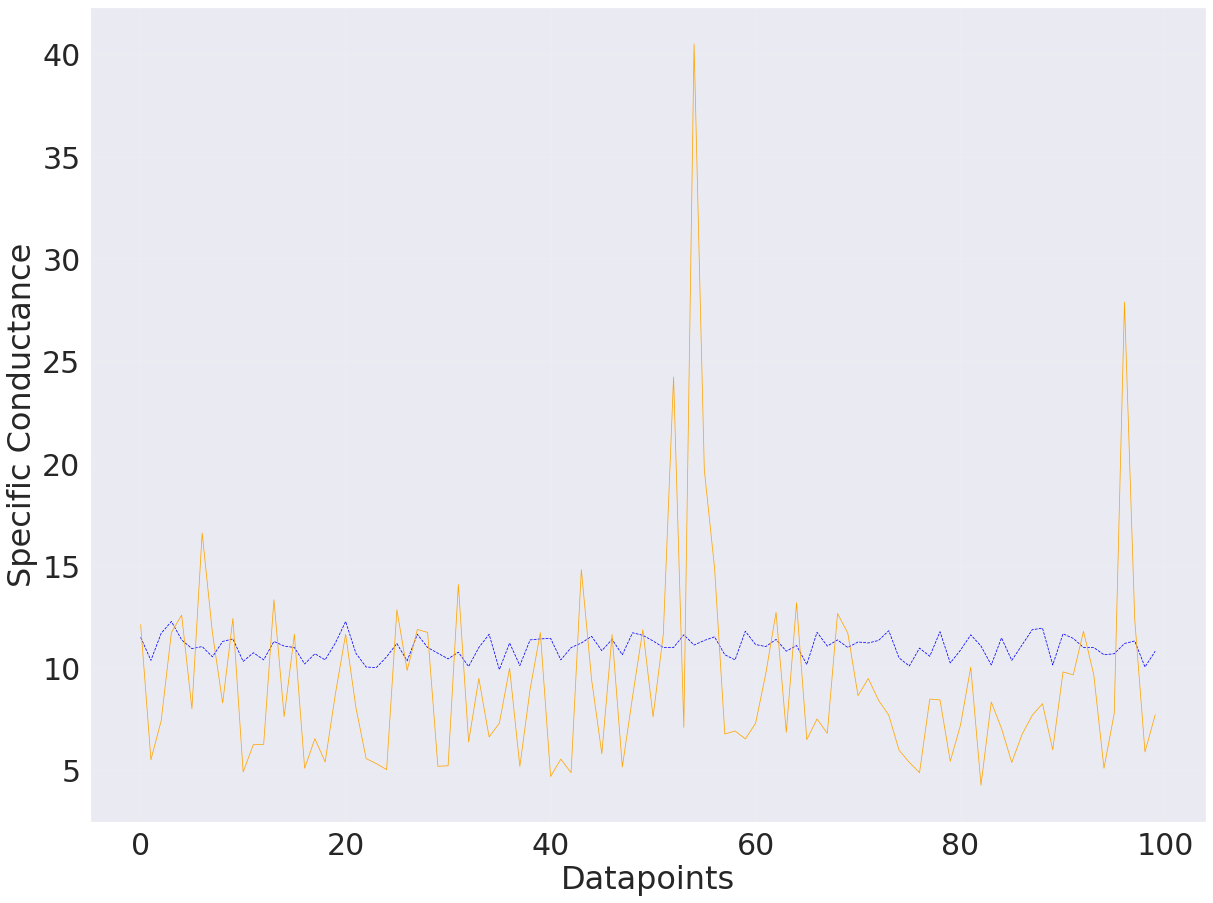

In [ ]:
plt.figure(figsize=(20,15))
#denormalized_y = yhat * (12200.0 - 0) + 0
pyplot.xticks(size = 30)
pyplot.yticks(size = 30)
pyplot.rcParams["figure.figsize"] = (15,12)
pyplot.plot(Y_train.head(100), color ='blue', linestyle = 'dashed', linewidth=0.75)
pyplot.plot(lstm_train_pred.head(100), color ='orange', linestyle = 'solid', linewidth=0.75)
#pyplot.plot(denormalized_y.iloc[50000:63766], color ='green', linestyle = 'solid', linewidth=0.75)
pyplot.xlabel('Datapoints', fontsize = 32)
pyplot.ylabel('Specific Conductance', fontsize = 32)
#pyplot.ylim(0, 12500)
#pyplot.legend(loc="upper left")

#pyplot.legend(["Observed", "Train set", "Test set"], loc ="upper left", fontsize=28)
ax = plt.axes()  
pyplot.grid(which='major', color='white', linestyle='-', linewidth=0.1)

##P2 BTI

In [ ]:
df = pd.read_csv('/content/drive/My Drive/P2/df_hourly.csv')
df.head()

,Date,Elapsed Time (Hours),Total inflow (in/hr),Total Evap (in/hr),Surface Infil (in/hr),Pavement Perc (in/hr),Soil Perc (in/hr),Storage Exfil (in/hr),Surface Runoff,Drain Outflow (in/hr),...,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Water_Depth,Recession_Rate,LSTM_RR,swmm_RR1
0,2014-01-05 10:00:00,106.6250,0.462,0.0000,0.462,0.0,0.0,0.0,0.0,0.0,...,-0.1525,2.1020,0.329047,0.349285,0.310158,0.377618,0.41,0.0,0.086763,0.0076
1,2014-01-05 11:00:00,107.2500,1.164,0.0007,0.736,0.0,0.0,0.0,0.0,0.0,...,0.0370,2.0958,0.329047,0.349285,0.310158,0.377618,0.41,0.0,0.071223,0.0442
2,2014-01-05 12:00:00,108.7500,0.055,0.0000,0.055,0.0,0.0,0.0,0.0,0.0,...,0.5210,2.0908,0.329047,0.349285,0.310158,0.377618,0.41,0.0,0.083742,0.0000
3,2014-01-05 13:00:00,109.4585,0.025,0.0000,0.025,0.0,0.0,0.0,0.0,0.0,...,0.8785,2.0880,0.330396,0.350634,0.310158,0.377618,0.41,0.0,0.089855,0.0238
4,2014-01-05 14:00:00,110.4585,0.903,0.0007,0.454,0.0,0.0,0.0,0.0,0.0,...,0.7270,2.0879,0.333095,0.351983,0.310158,0.377618,0.41,0.0,0.095038,0.0886


In [ ]:
print(list(df))

['Date', 'Elapsed Time (Hours)', 'Total inflow (in/hr)', 'Total Evap (in/hr)', 'Surface Infil (in/hr)', 'Pavement Perc (in/hr)', ' Soil Perc (in/hr)', 'Storage Exfil (in/hr)', 'Surface Runoff', 'Drain Outflow (in/hr)', 'Surface Level (inch)', 'Pavement Level (inch)', 'Soil Moisture', 'Storage Level (inch)', 'swmm_RR', 'Precipitation', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Water_Depth', 'Recession_Rate', 'LSTM_RR', 'swmm_RR1']


In [ ]:
series = df[['Precipitation', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Water_Depth', 'Recession_Rate']].head(90000)

In [ ]:
se = series

In [ ]:
se

,Precipitation,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Water_Depth,Recession_Rate
0,0.0,-0.1525,2.1020,0.329047,0.349285,0.310158,0.377618,0.41,0.0
1,0.0,0.0370,2.0958,0.329047,0.349285,0.310158,0.377618,0.41,0.0
2,0.0,0.5210,2.0908,0.329047,0.349285,0.310158,0.377618,0.41,0.0
3,0.0,0.8785,2.0880,0.330396,0.350634,0.310158,0.377618,0.41,0.0
4,0.0,0.7270,2.0879,0.333095,0.351983,0.310158,0.377618,0.41,0.0
...,...,...,...,...,...,...,...,...,...
43690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
43691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
43692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
43693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
window = 100
lag = 5
series = series_to_supervised(se, window=window, lag=lag)
series.head()

,Precipitation(t-100),Temp_Air(t-100),Temp_Moist(t-100),Soil_MC_10(t-100),Soil_MC_35(t-100),Soil_MC_65(t-100),Soil_MC_91(t-100),Water_Depth(t-100),Recession_Rate(t-100),Precipitation(t-99),...,Recession_Rate(t),Precipitation(t+5),Temp_Air(t+5),Temp_Moist(t+5),Soil_MC_10(t+5),Soil_MC_35(t+5),Soil_MC_65(t+5),Soil_MC_91(t+5),Water_Depth(t+5),Recession_Rate(t+5)
335,0.0,-0.1470,2.5214,0.450474,0.469363,0.428887,0.408649,0.41,0.0,0.0,...,0.0,0.0,2.6120,1.7158,0.322301,0.354682,0.311507,0.378967,0.41,0.0
336,0.0,0.0640,2.5213,0.449800,0.470038,0.428887,0.409999,0.41,0.0,0.0,...,0.0,0.0,2.8955,1.7066,0.322301,0.353332,0.311507,0.378967,0.41,0.0
337,0.0,0.3920,2.4908,0.449125,0.470038,0.428887,0.409999,0.41,0.0,0.0,...,0.0,0.0,2.7595,1.6973,0.322301,0.353332,0.311507,0.378967,0.41,0.0
338,0.0,1.2180,2.4627,0.449125,0.469363,0.428887,0.409999,0.41,0.0,0.0,...,0.0,0.0,1.4365,1.7014,0.322301,0.353332,0.311507,0.378967,0.41,0.0
339,0.0,2.7825,2.4380,0.430911,0.469363,0.428887,0.409999,0.41,0.0,0.0,...,0.0,0.0,0.5055,1.7006,0.322301,0.353332,0.311507,0.378967,0.41,0.0


In [ ]:
series

,Precipitation(t-100),Temp_Air(t-100),Temp_Moist(t-100),Soil_MC_10(t-100),Soil_MC_35(t-100),Soil_MC_65(t-100),Soil_MC_91(t-100),Water_Depth(t-100),Recession_Rate(t-100),Precipitation(t-99),...,Recession_Rate(t),Precipitation(t+5),Temp_Air(t+5),Temp_Moist(t+5),Soil_MC_10(t+5),Soil_MC_35(t+5),Soil_MC_65(t+5),Soil_MC_91(t+5),Water_Depth(t+5),Recession_Rate(t+5)
335,0.0,-0.1470,2.5214,0.450474,0.469363,0.428887,0.408649,0.41,0.0,0.0,...,0.000,0.00,2.6120,1.7158,0.322301,0.354682,0.311507,0.378967,0.4100,0.000
336,0.0,0.0640,2.5213,0.449800,0.470038,0.428887,0.409999,0.41,0.0,0.0,...,0.000,0.00,2.8955,1.7066,0.322301,0.353332,0.311507,0.378967,0.4100,0.000
337,0.0,0.3920,2.4908,0.449125,0.470038,0.428887,0.409999,0.41,0.0,0.0,...,0.000,0.00,2.7595,1.6973,0.322301,0.353332,0.311507,0.378967,0.4100,0.000
338,0.0,1.2180,2.4627,0.449125,0.469363,0.428887,0.409999,0.41,0.0,0.0,...,0.000,0.00,1.4365,1.7014,0.322301,0.353332,0.311507,0.378967,0.4100,0.000
339,0.0,2.7825,2.4380,0.430911,0.469363,0.428887,0.409999,0.41,0.0,0.0,...,0.000,0.00,0.5055,1.7006,0.322301,0.353332,0.311507,0.378967,0.4100,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43332,0.0,-1.9765,3.3320,0.309000,0.326000,0.297000,0.406000,0.41,0.0,0.0,...,0.000,0.01,4.5200,4.8447,0.384000,0.392000,0.438000,0.407000,1.2735,1.152
43333,0.0,-2.6735,3.3252,0.309000,0.325500,0.297000,0.406000,0.41,0.0,0.0,...,0.000,0.01,3.9640,4.8598,0.385000,0.391500,0.439000,0.408000,1.3865,1.152
43334,0.0,-1.1775,3.3214,0.309000,0.325000,0.297000,0.406000,0.41,0.0,0.0,...,0.000,0.01,3.7280,4.8478,0.386000,0.394000,0.439000,0.408000,1.4790,1.008
43335,0.0,-1.2875,3.3186,0.309000,0.325000,0.297000,0.406000,0.41,0.0,0.0,...,2.160,0.01,3.7240,4.8358,0.386000,0.395000,0.440000,0.408000,1.5000,0.000


In [ ]:
# last_q = 'Discharge(t-%d)' % window
# last_h = 'Water Level(t-%d)' % window
# series = series[(series['Discharge(t)'] == series[last_h])]
# series = series[(series['Water Level(t)'] == series[last_q])]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Label
labels_col = 'Recession_Rate(t+%d)' % 5
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (8091, 917)
Validation set shape (2023, 917)


,Precipitation(t-100),Temp_Air(t-100),Temp_Moist(t-100),Soil_MC_10(t-100),Soil_MC_35(t-100),Soil_MC_65(t-100),Soil_MC_91(t-100),Water_Depth(t-100),Recession_Rate(t-100),Precipitation(t-99),...,Water_Depth(t),Recession_Rate(t),Precipitation(t+5),Temp_Air(t+5),Temp_Moist(t+5),Soil_MC_10(t+5),Soil_MC_35(t+5),Soil_MC_65(t+5),Soil_MC_91(t+5),Water_Depth(t+5)
6258,0.0,13.5950,18.5960,0.2845,0.291,0.298,0.3560,0.41,0.0,0.0,...,0.4100,0.00,0.00,15.2300,18.2730,0.263,0.279,0.2880,0.354,0.4100
33234,0.0,6.0115,18.3360,0.3090,0.304,0.273,0.4020,0.41,0.0,0.0,...,0.4100,0.00,0.00,18.5100,16.3710,0.281,0.286,0.2680,0.400,0.4100
34730,0.0,0.8515,5.1802,0.3260,0.307,0.276,0.4105,0.41,0.0,0.0,...,0.4100,0.00,0.00,6.7625,5.5706,0.316,0.302,0.2740,0.412,0.4100
29373,0.0,5.1305,12.4060,0.3190,0.304,0.267,0.4260,0.41,0.0,0.0,...,1.2425,2.88,0.01,10.4750,12.0400,0.376,0.404,0.4275,0.427,1.9755
37071,0.0,-0.3380,1.9113,0.3585,0.357,0.325,0.4240,0.41,0.0,0.0,...,0.4600,0.00,0.00,15.4500,4.8800,0.373,0.386,0.4370,0.423,0.4100


In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (8091, 917, 1)
Validation set shape (2023, 917, 1)


In [ ]:
from keras import optimizers
lr = 0.0003

In [ ]:
adam = optimizers.Adam(lr)

In [ ]:
X_train_series.shape[0]

8091

In [ ]:
from tensorflow.keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
model_lstm.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                10400     
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_shape=(X_train_series.shape[1], X_train_series.shape[2])

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
epochs = 5
batch = 256

In [ ]:
#lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/5
253/253 - 87s - loss: 0.0947 - val_loss: 0.0338 - 87s/epoch - 343ms/step
Epoch 2/5
253/253 - 86s - loss: 0.0936 - val_loss: 0.0322 - 86s/epoch - 340ms/step
Epoch 3/5
253/253 - 89s - loss: 0.0931 - val_loss: 0.0312 - 89s/epoch - 353ms/step
Epoch 4/5
253/253 - 87s - loss: 0.0927 - val_loss: 0.0330 - 87s/epoch - 343ms/step
Epoch 5/5
253/253 - 87s - loss: 0.0918 - val_loss: 0.0309 - 87s/epoch - 344ms/step


In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

64/64 [==============================] - 6s 95ms/step
Train rmse: 0.30206028182249417
Validation rmse: 0.17582601986530264


In [ ]:
Y_train.shape

(8091,)

In [ ]:
lstm_train_pred.shape

(8091, 1)

In [ ]:
lstm_train_pred

array([[ 0.0101374 ],
       [ 0.00908267],
       [ 0.01730736],
       ...,
       [-0.0090838 ],
       [ 0.42251852],
       [ 0.03589822]], dtype=float32)

In [ ]:
lstm_train_pred = pd.DataFrame(lstm_train_pred, columns = ['lstm_train_pred'])

In [ ]:
lstm_train_pred

,lstm_train_pred
0,0.010137
1,0.009083
2,0.017307
3,0.518032
4,0.023989
...,...
8086,0.006622
8087,-0.016820
8088,-0.009084
8089,0.422519


In [ ]:
Y_train = pd.DataFrame(Y_train, columns = ['ytrain'])

In [ ]:
lstm_train_pred

,lstm_train_pred
0,0.010137
1,0.009083
2,0.017307
3,0.518032
4,0.023989
...,...
8086,0.006622
8087,-0.016820
8088,-0.009084
8089,0.422519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


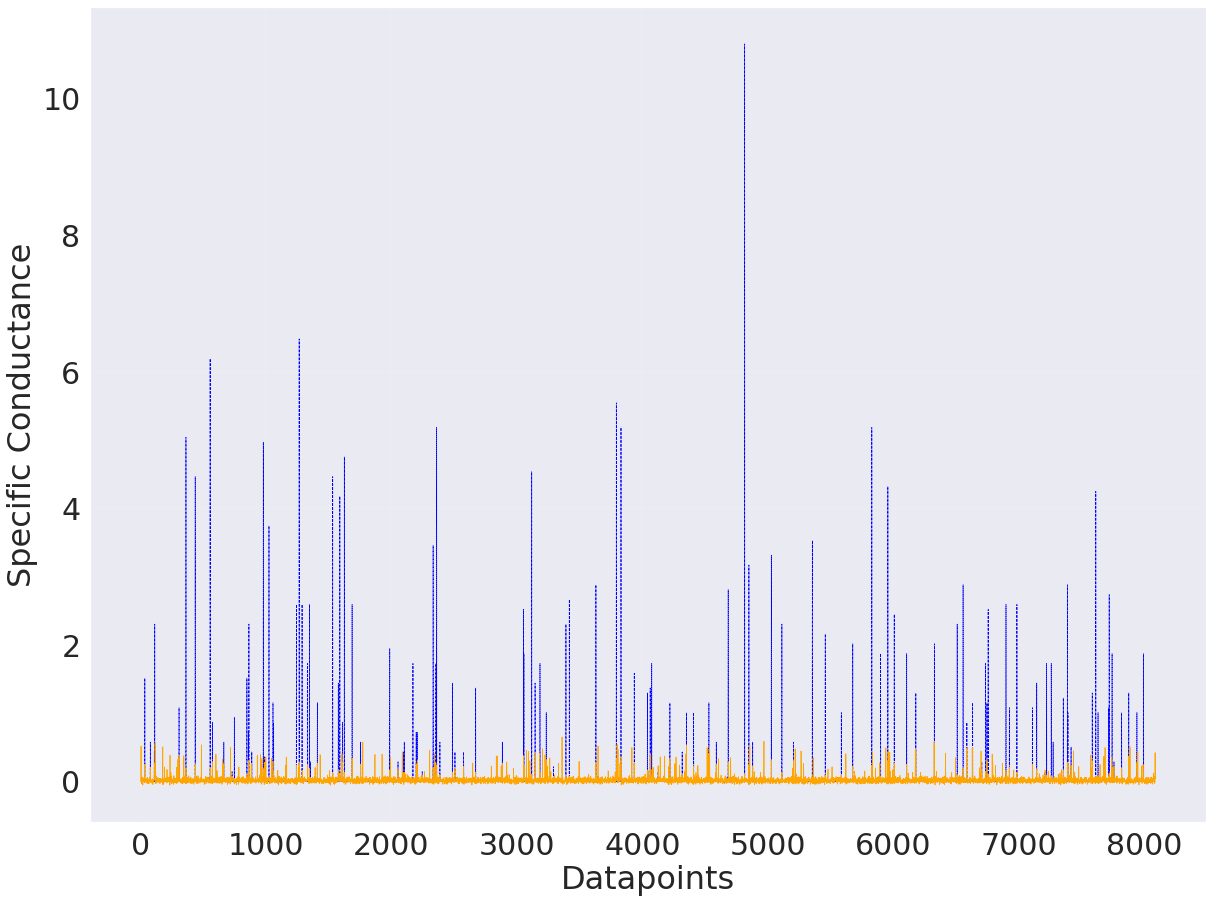

In [ ]:
plt.figure(figsize=(20,15))
#denormalized_y = yhat * (12200.0 - 0) + 0
pyplot.xticks(size = 30)
pyplot.yticks(size = 30)
pyplot.rcParams["figure.figsize"] = (15,12)
pyplot.plot(Y_train, color ='blue', linestyle = 'dashed', linewidth=0.75)
pyplot.plot(lstm_train_pred, color ='orange', linestyle = 'solid', linewidth=0.75)
#pyplot.plot(denormalized_y.iloc[50000:63766], color ='green', linestyle = 'solid', linewidth=0.75)
pyplot.xlabel('Datapoints', fontsize = 32)
pyplot.ylabel('Specific Conductance', fontsize = 32)
#pyplot.ylim(0, 12500)
#pyplot.legend(loc="upper left")

#pyplot.legend(["Observed", "Train set", "Test set"], loc ="upper left", fontsize=28)
ax = plt.axes()  
pyplot.grid(which='major', color='white', linestyle='-', linewidth=0.1)